In [1]:
# connect to h2o cluster:
import h2o
h2o.init(nthreads=-1, max_mem_size="8G")

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,12 secs
H2O cluster version:,3.10.4.1
H2O cluster version age:,"14 days, 23 hours and 32 minutes"
H2O cluster name:,H2O_from_python_jurgentas_gff901
H2O cluster total nodes:,1
H2O cluster free memory:,7.111 Gb
H2O cluster total cores:,0
H2O cluster allowed cores:,0
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [2]:
# The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant.
import pandas as pd

url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
names = ['sepal_lenght','sepal_width','petal_lenght','petal_with','class']
df = pd.read_csv(url, names = names)
df.head()

,sepal_lenght,sepal_width,petal_lenght,petal_with,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
# construct h2o dataframe:
df_hex = h2o.H2OFrame(df, column_names = df.columns.tolist())
df_hex.head()

Parse progress: |█████████████████████████████████████████████████████████| 100%


sepal_lenght,sepal_width,petal_lenght,petal_with,class
5.1,3.5,1.4,0.2,Iris-setosa
4.9,3,1.4,0.2,Iris-setosa
4.7,3.2,1.3,0.2,Iris-setosa
4.6,3.1,1.5,0.2,Iris-setosa
5,3.6,1.4,0.2,Iris-setosa
5.4,3.9,1.7,0.4,Iris-setosa
4.6,3.4,1.4,0.3,Iris-setosa
5,3.4,1.5,0.2,Iris-setosa
4.4,2.9,1.4,0.2,Iris-setosa
4.9,3.1,1.5,0.1,Iris-setosa


In [4]:
#'hockeystick' method to determine optimal number of columns:
# https://en.wikipedia.org/wiki/Elbow_method_(clustering)

from h2o.estimators.kmeans import H2OKMeansEstimator
results = [H2OKMeansEstimator(k=clusters, init='Random', seed=123, nfolds = 10, standardize=True, 
                              max_iterations = 100) for clusters in range(2,8)]
for estimator in results:
    estimator.train(x = ['sepal_lenght','sepal_width','petal_lenght','petal_with'], training_frame = df_hex)

kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%


In [5]:
# diagnostics function:

import math as math

def diagnostics_from_clusteringmodel(model):
    total_within_sumofsquares = model.tot_withinss()
    number_of_clusters = len(model.centers())
    number_of_dimensions = len(model.centers()[0])
    number_of_rows = sum(model.size())
    
    aic = total_within_sumofsquares + 2 * number_of_dimensions * number_of_clusters
    bic = total_within_sumofsquares + math.log(number_of_rows) * number_of_dimensions * number_of_clusters
    
    return {'Clusters':number_of_clusters,
            'Total Within SS':total_within_sumofsquares, 
            'AIC':aic, 
            'BIC':bic}

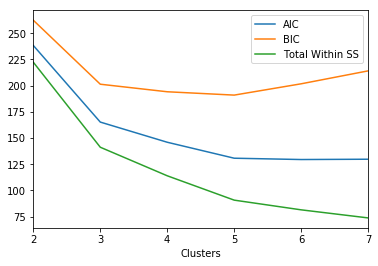

In [6]:
# plot results:
%matplotlib inline
diagnostics = pd.DataFrame( [diagnostics_from_clusteringmodel(model) for model in results])
diagnostics.set_index('Clusters', inplace=True)
diagnostics.plot(kind='line');

In [7]:
# single kmeans:
clusters = 3
model = results[clusters-2]
model.summary()

Model Summary: 


,number_of_rows,number_of_clusters,number_of_categorical_columns,number_of_iterations,within_cluster_sum_of_squares,total_sum_of_squares,between_cluster_sum_of_squares
,150.0,3.0,0.0,9.0,141.1632329,596.0,454.8367671


In [8]:
# allocate to clusters:
pred = model.predict(df_hex)
df_hex["predicted"] = pred["predict"].asfactor()
df_hex.head()

kmeans prediction progress: |█████████████████████████████████████████████| 100%


sepal_lenght,sepal_width,petal_lenght,petal_with,class,predicted
5.1,3.5,1.4,0.2,Iris-setosa,0
4.9,3,1.4,0.2,Iris-setosa,0
4.7,3.2,1.3,0.2,Iris-setosa,0
4.6,3.1,1.5,0.2,Iris-setosa,0
5,3.6,1.4,0.2,Iris-setosa,0
5.4,3.9,1.7,0.4,Iris-setosa,0
4.6,3.4,1.4,0.3,Iris-setosa,0
5,3.4,1.5,0.2,Iris-setosa,0
4.4,2.9,1.4,0.2,Iris-setosa,0
4.9,3.1,1.5,0.1,Iris-setosa,0


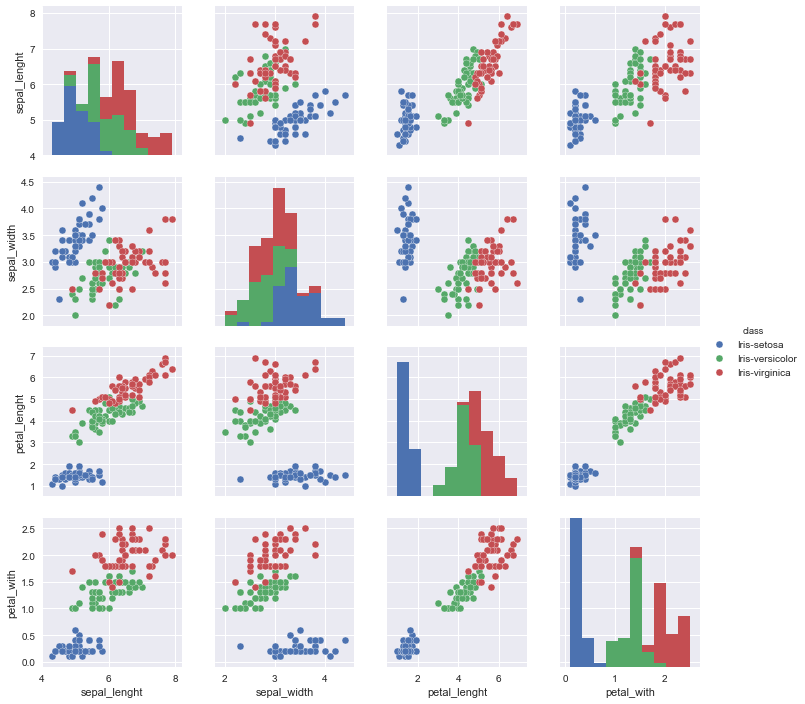

In [9]:
# visualisation 1:
import seaborn as sns
%matplotlib inline
sns.set()
sns.pairplot(df_hex.as_data_frame(True), vars=['sepal_lenght','sepal_width','petal_lenght','petal_with'],  
             hue="class");

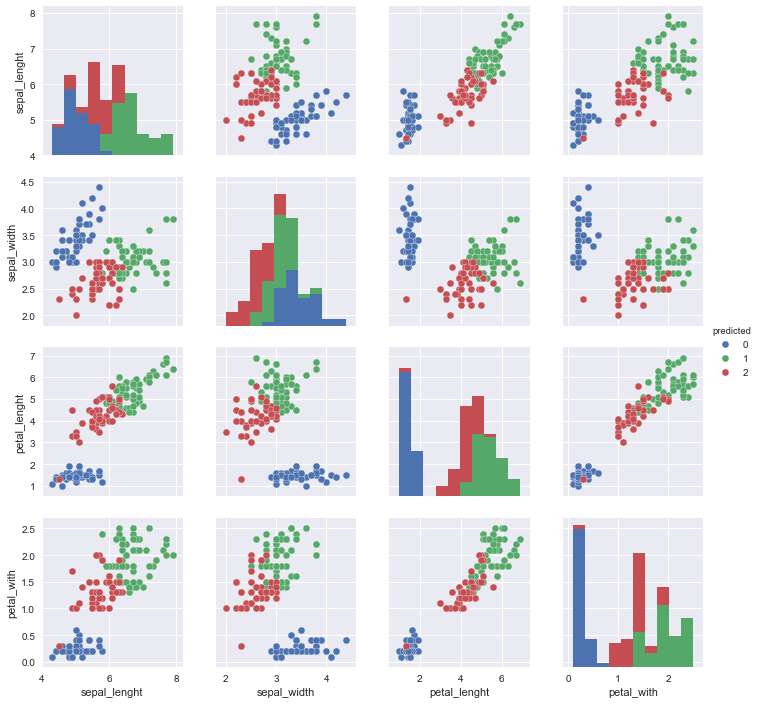

In [10]:
# visualisation 2:
%matplotlib inline
sns.set()
sns.pairplot(df_hex.as_data_frame(True), vars=['sepal_lenght','sepal_width','petal_lenght','petal_with'],  
             hue="predicted");

In [11]:
h2o.cluster().shutdown()

H2O session _sid_8b4d closed.
